# Camera Calibration and 3D Reconstruction

## Camera Calibration

### Goal

In this section,

* We will learn about distortions in camera, intrinsic and extrinsic parameters of camera etc.

### Basics

#### What is camera calibration?

For applications like object detection, we need to know what object is where. For that, we need to know camera properties and its parameters. For example, what are all the distortions in that camera? What is focal length of camera? What is optical center of camera lens? These information is intrinsic to that camera. We also need to know the position of camera in world co-ordinate system. These information is extrinsic to camera. So in short, we need to find the relation between points of 3D world and 2D image. Finding these intrinsic and extrinsic parameters of camera is called **camera calibration**.

#### Camera Types

There are various types of camera models available like pinhole camera model, fisheye camera model etc. Most popular one is pinhole camera model. It is simple. Once we get intrinsic parameters of camera, we can use it to correct the distortions in real time. 

#### Distortions

There are two types of distortions:

* Radial Distortion
* Tangential Distortion

##### Radial Distortion

Straight lines will appear curved in images. It is caused by the unequal scaling of axes. So once we know camera parameters, we can correct this distortion.

##### Tangential Distortion

It occurs because image taking lense is not aligned perfectly parallel to the imaging plane. So some areas in image may look nearer than expected.

#### Intrinsic Parameters

Intrinsic parameters are specific to a camera. It includes information like focal length $(f_x, f_y)$, optical centers $(c_x, c_y)$ etc. It is also called camera matrix. It depends on the camera only, so once calculated, it can be stored for future purposes. It is expressed as a 3x3 matrix:

$$
cameraMatrix = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

#### Extrinsic Parameters

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

So with the help of these parameters, we can find the 3D world coordinates of any point in that image if we know its coordinates in that image and vice-versa.

#### So what we do is

* We take 10-20 images of a chess board.
* We find some specific points in it ( square corners in chess board).
* We know its coordinates in real world space and we know its coordinates in image.
* With these data, some mathematical problem is solved in background to get the distortion coefficients, camera matrix etc. which are the intrinsic parameters of that camera.
* Now we can take an image, undistort it, use cv2.remap() to remap the pixels to canonical image and get a image without distortion.

### Code

We need at least 10 test patterns for camera calibration. We are using chess board as test pattern. The important input data needed for calibration of the camera is the set of 3D real world points and the corresponding 2D coordinates of these points in the image. 2D images points are OK which we can easily find from the image. (These image points are locations where two black squares touch each other in chess boards).  

What about the 3D points from real world space? Those images are taken from a static camera and chess boards are placed at different locations and orientations. So we need to know (X,Y,Z) values. But for simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), and we can pass the values as (0,0),(30,0),(60,0),..., we get the results in mm. (In this case, we don't know square size since we didn't take those images, so we pass in terms of square size).

3D points are called object points and 2D image points are called image points.

#### Setup

So to find pattern in chess board, we can use the function, cv2.findChessboardCorners(). We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. (Normally a chess board has 8x8 squares and 7x7 internal corners). It returns the corner points and retval which will be True if pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom)

##### Note
This function cannot find the chess board corners in all the images. So one good option is to write our own code so it starts the camera and check each frame for required pattern. If found, add to a list of found corners. Even if a failure happens in middle, we can take next image and continue the process. 

Instead of chess board, we can use some circular grid, but then use cv2.findCirclesGrid() to find the pattern. It is said that less number of images are enough when using circular grid.

Once we find the corners, we can increase their accuracy using cv2.cornerSubPix(). We can also draw the pattern using cv2.drawChessboardCorners().

In [1]:
# data folder is obtained from opencv github repo
import numpy as np
import cv2 as cv
# to get the file pathnames
import glob

# termination criteria
# Criteria for termination of the iterative process of corner refinement.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
# 3d point in real world space
objpoints = []
# 2d points in image plane.
imgpoints = []
# Get all the file pathnames
images = glob.glob('data/left*.jpg')



for fname in images:
    # Read the image
    img = cv.imread(fname)
    # Convert to grayscale
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        # Add the object points
        objpoints.append(objp)
        # Refine the image points
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Add the image points
        imgpoints.append(corners2)
        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (7,6), corners2,ret)
        cv.imshow('img',img)
        cv.waitKey(500)

cv.destroyAllWindows()

2023-10-22 19:16:24.319 Python[29427:2900741] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


#### Calibration

So now we have our object points and image points we are ready to go for calibration. For that we use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [2]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

#### Undistortion

Now, we can take an image and undistort it. OpenCV comes with two methods, we will see both. But before that, we can refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

So, we take a new image (left12.jpg)

In [8]:
img = cv.imread('data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

1. Using cv2.undistort()
This is the easiest way. Just call the function and use ROI obtained above to crop the result.

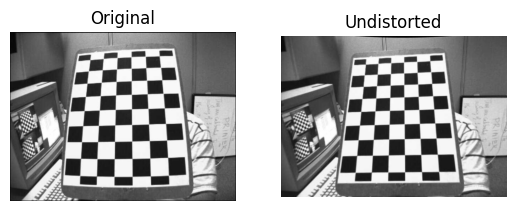

In [13]:
import matplotlib.pyplot as plt
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()


2. Using remapping

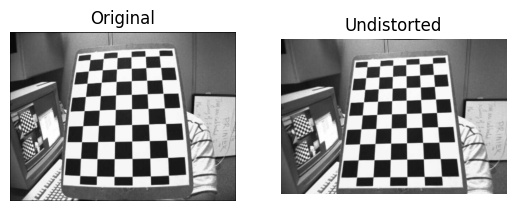

In [15]:
# undistort
mapx,mapy = cv.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv.remap(img,mapx,mapy,cv.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()

You can see the result in below image. Image is clearer at corners.

Now we can store the camera matrix and distortion coefficients using write functions in Numpy (np.savez, np.savetxt etc) for future uses.

#### Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. Given the intrinsic, distortion, rotation and translation matrices, we first transform the object point to image point using cv2.projectPoints(). Then we calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error we calculate the arithmetical mean of the errors calculate for all the calibration images.

In [16]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i],imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.023685996975391924


In [ ]:
# circular grid distortion correction proposition (not working)
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# Prepare grid points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
gridp = np.zeros((6*7,3), np.float32)
gridp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Get all the file pathnames
images = glob.glob('path/to/circular/grids') # circular grid images

for fname in images:
    # Read the image
    img = cv.imread(fname)
    # Convert to grayscale
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find the grid corners
    ret, corners = cv.findCirclesGrid(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        # Add the object points
        objpoints.append(gridp)
        # Refine the image points
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Add the image points
        imgpoints.append(corners2)
        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (7,6), corners2,ret)
        cv.imshow('img',img)
        cv.waitKey(500)

cv.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

img = cv.imread('data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

import matplotlib.pyplot as plt
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()


: 